In [1]:
import numpy as np
from astropy.io import fits
from DS_healpix_fragmentation import one_pixel_fragmentation
from DS_Planck_Unet import draw_pic, check_gen, unet_planck, gen_data
import healpy as hp
from matplotlib import pyplot as plt

In [14]:
nilc = None
with fits.open('/home/rt2122/Data/Planck/y/nilc_ymaps.fits') as hdul:
    data = hdul[1].data
    print(repr(hdul[1].header))
    nilc = np.array(data['FULL'])

XTENSION= 'BINTABLE'           /Written by IDL:  Sun Feb  1 15:05:26 2015       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   16 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    4 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2015-02-01'      

In [15]:
nilc.shape, hp.nside2npix(2048) 

((50331648,), 50331648)

In [17]:
np.save('/home/rt2122/Data/Planck/normalized/y/nilc', nilc)

In [7]:
def draw_pic_new(matr, dirname='/home/rt2122/Data/Planck/normalized/', y=False):
    import os
    import numpy as np
   
    if y:
        dirname = os.path.join(dirname, 'y')
        
    files = sorted(next(os.walk(dirname))[-1])
    pic = np.zeros(list(matr.shape) + [len(files)])
    
    for i_f, file in enumerate(files):
        i_s = np.load(os.path.join(dirname, file))
        
        for x in range(pic.shape[0]):
            pic[x, :, i_f] = i_s[matr[x]]
    return pic


In [8]:
matr = one_pixel_fragmentation(2, 6, 10)

In [18]:
ypic = draw_pic_new(matr, y=True)

In [16]:
nilc = nilc.astype(np.float64)

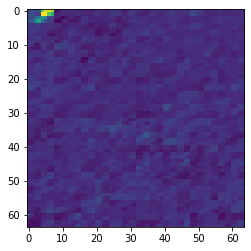

In [22]:
plt.imshow(ypic[:64,:64,0])

In [2]:
model = unet_planck(
    weights='/home/rt2122/Models/planck_z/b40.ep0011-vl0.121560-l0.125252.h5')

In [3]:
test_gen = gen_data('/home/rt2122/Data/clusters/planck_z.csv', [6], 1, 
                    min_rad=0.08, retmatr=True) 

(1, 64, 64, 6) (1, 64, 64, 1)


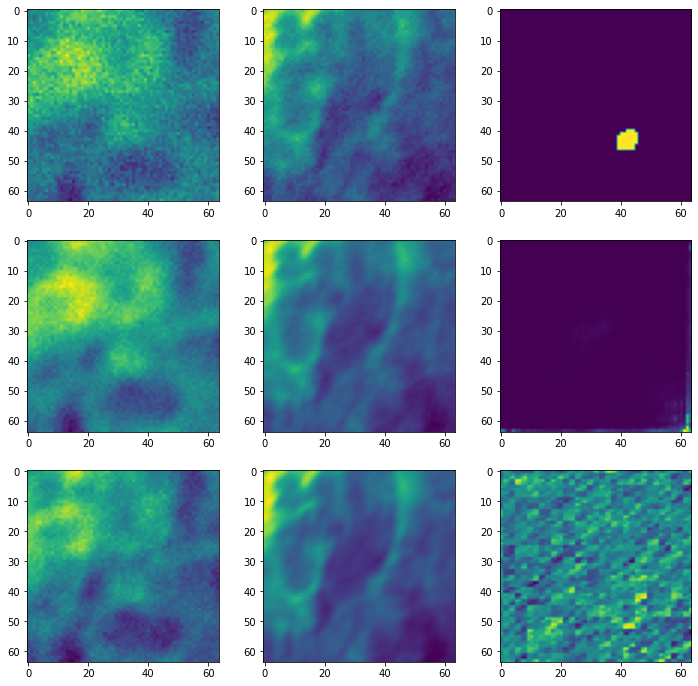

In [12]:
check_gen_new(test_gen, model, y=True)

In [11]:
def check_gen_new(gen, model=None, thr=0.8, y=False):
    from matplotlib import pyplot as plt
    import numpy as np
    pic, mask, matr = None, None, None
    if y:
        pic, mask, matr = next(gen)
    else:
        pic, mask = next(gen)
    print(pic.shape, mask.shape)
    pic = pic[0]
    mask = mask[0]
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        for j in range(2):
            ax[i][j].imshow(pic[:,:,i+3*j])
    ax[0][2].imshow(mask[:,:,0])
    if not (model is None):
        ans = model.predict(np.array([pic]))
        ax[1][2].imshow(ans[0,:,:,0])
        if y:
            cpic = draw_pic(matr[0], y=True)
            ax[2][2].imshow(cpic[:,:,0])
        else:
            ax[2][2].imshow((ans[0,:,:,0] >= thr).astype(np.float32))